# SEEK + UNSW COMP6713 -Group Project 2025 Term 1

Pre-Neural Network

In [1]:
import torch
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from tqdm import tqdm
import re
from sklearn_crfsuite import CRF, metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sentence_transformers import SentenceTransformer, util
import numpy as np
from thefuzz import fuzz

warnings.filterwarnings("ignore")

## Work Arrangement

In [2]:
label_map = {"Remote": 0, "OnSite": 1, "Hybrid": 2}

fields = {
    "Job title": "TITLE",
    "Abstract": "ABSTRACT",
    "Employer": "EMPLOYER",
    "Location": "LOCATION",
    "Highlights": "HIGHLIGHTS",
    "Contents": "CONTENTS",
}

def parse_arrange_text(text):
    result = {}
    current_field = None

    for line in text.splitlines():
        line = line.strip()

        if not line:
            continue

        m = re.match(r"^([A-Za-z ]+): (.*)$", line)

        if m and m.group(1) in ["Job title", "Abstract", "Employer", "Location", "Highlights", "Contents"]:
            current_field = m.group(1)
            result[current_field] = m.group(2).strip()
        elif current_field:
            result[current_field] += " " + line

    result_list = []
    for key, value in result.items():
        if key in fields:
            result_list.append(f" {value} ")

    return " ".join(result_list)

In [12]:
df = pd.read_csv('dataset/work_arrangements_development_set.csv')
df["input_list"] = df["job_ad"].apply(lambda x: parse_arrange_text(x))
df["label_idx"] =df["y_true"].map(label_map)

#### Train

In [14]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("svc", SVC(
        C=1.0,
        kernel="linear",
        probability=True,
        random_state=42
    )),
])

pipeline.fit(df["input_list"], df["label_idx"])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('svc',
                 SVC(kernel='linear', probability=True, random_state=42))])

#### Test

In [15]:
df = pd.read_csv('dataset/work_arrangements_test_set.csv')
df["input_list"] = df["job_ad"].apply(lambda x: parse_arrange_text(x))
df["label_idx"] =df["y_true"].map(label_map)

In [16]:
pred = pipeline.predict(df["input_list"])

In [17]:
acc  = accuracy_score(df["label_idx"], pred)
prec = precision_score(df["label_idx"], pred, average="macro")
rec  = recall_score(df["label_idx"], pred, average="macro")
f1   = f1_score(df["label_idx"], pred, average="macro")

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.6263
Precision: 0.6788
Recall   : 0.5649
F1-score : 0.5330


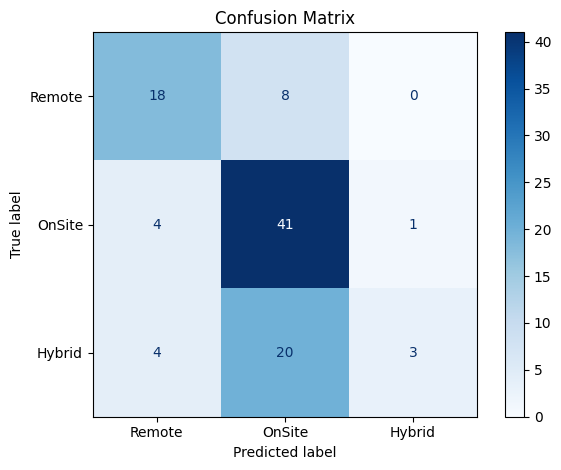

In [23]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=df["label_idx"],
    y_pred=pred,
    display_labels=label_map.keys(),
    cmap="Blues",
    normalize=None
)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Seniority

In [43]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text(" ", strip=True)

In [44]:
def parse_salary_row(row):
    parts = []

    if pd.notna(row["job_title"]):
        parts.append(f" {row['job_title'].strip()} ")

    if pd.notna(row["job_summary"]):
        parts.append(f" {row['job_summary'].strip()} ")

    if pd.notna(row["temp"]):
        parts.append(f" {row['temp'].strip()} ")

    if pd.notna(row["classification_name"]):
        parts.append(f" {row['classification_name'].strip()} ")

    if pd.notna(row["subclassification_name"]):
        parts.append(f" {row['subclassification_name'].strip()} ")

    return " ".join(parts)

In [45]:
df = pd.read_csv('dataset/seniority_labelled_development_set.csv')
df["temp"] = df["job_ad_details"].apply(lambda x: remove_html_tags(x))
df["input_list"] = df.apply(parse_salary_row, axis=1)

#### Train

In [47]:
clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("svc", SVC(
        kernel="linear",
        C=1.0,
        probability=False,
        random_state=42
    )),
])
clf.fit(df["input_list"], df["y_true"])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('svc', SVC(kernel='linear', random_state=42))])

#### Test

In [56]:
sbert = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
alpha = 0.5

def compute_word_metrics(preds: list[str], refs: list[str]) -> dict:
    pairs = [(p, r) for p, r in zip(preds, refs) if p and r]
    if not pairs:
        return {
            "mean_semantic_similarity": 0.0,
            "mean_string_similarity":   0.0,
            "mean_hybrid_similarity":   0.0,
            "exact_match_rate":         0.0,
        }
    ps, rs = zip(*pairs)

    emb_p = sbert.encode(ps, convert_to_tensor=True)
    emb_r = sbert.encode(rs, convert_to_tensor=True)
    sem_sims = util.cos_sim(emb_p, emb_r).diagonal().cpu().numpy()

    str_sims = np.array([fuzz.ratio(p, r)/100.0 for p, r in zip(ps, rs)])

    hybrid = alpha * sem_sims + (1 - alpha) * str_sims

    exact = np.array([1.0 if p == r else 0.0 for p, r in zip(ps, rs)])

    return {
        "mean_semantic_similarity": float(sem_sims.mean()),
        "mean_string_similarity":   float(str_sims.mean()),
        "mean_hybrid_similarity":   float(hybrid.mean()),
        "exact_match_rate":         float(exact.mean()),
    }

In [57]:
df = pd.read_csv('dataset/seniority_labelled_test_set.csv')
df["temp"] = df["job_ad_details"].apply(lambda x: remove_html_tags(x))
df["input_list"] = df.apply(parse_salary_row, axis=1)

In [52]:
preds = []

for text in tqdm(df['input_list']):
    pred = clf.predict([text])[0]
    preds.append(pred)

100%|███████████████████████████████████████████████████████████████████████████████| 689/689 [00:02<00:00, 270.68it/s]


In [63]:
metrics = compute_word_metrics(preds, df['y_true'].tolist())
print("Overall metrics:", metrics)

Overall metrics: {'mean_semantic_similarity': 0.6835365295410156, 'mean_string_similarity': 0.6276052249637155, 'mean_hybrid_similarity': 0.6555708890175784, 'exact_match_rate': 0.45573294629898403}


## Salary

In [2]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text(" ", strip=True)

In [3]:
def parse_salary_row(row):
    parts = []

    if pd.notna(row["job_title"]):
        parts.append(f" {row['job_title'].strip()} ")

    if pd.notna(row["temp"]):
        parts.append(f" {row['temp'].strip()} ")

    if pd.notna(row["nation_short_desc"]):
        parts.append(f" {row['nation_short_desc'].strip()} ")

    if pd.notna(row["salary_additional_text"]):
        parts.append(f" {row['salary_additional_text'].strip()} ")

    return " ".join(parts).replace("\n", " ").replace("\r", " ").replace("\t", " ").strip()

In [4]:
df = pd.read_csv('dataset/salary_labelled_development_set.csv')
df["temp"] = df["job_ad_details"].apply(lambda x: remove_html_tags(x))
df["input_list"] = df.apply(parse_salary_row, axis=1)

In [5]:
period = { 'MONTHLY': 0, 'HOURLY': 1, 'ANNUAL': 2, 'DAILY': 3, 'WEEKLY': 4, 'OTHER': 5  }
currency = { 'PHP': 0, 'HKD': 1, 'NZD': 2, 'MYR': 3, 'AUD': 4, 'SGD': 5, 'THB': 6, 'IDR': 7, 'USD': 8, 'OTHER': 9 }

df = pd.read_json('dataset/label.json')
mask = df['label'].isna() & (df['y_true'] != '0-0-None-None')
df = df.loc[~mask].reset_index(drop=True)
df['label'] = df['label'].apply(lambda x: x if isinstance(x, list) else [])
df['currency'] = df['y_true'].apply(lambda x: currency.get(x.split('-')[2], 9))
df['period'] = df['y_true'].apply(lambda x: period.get(x.split('-')[3], 5))

#### Train Min and Max Span Extraction

In [6]:
def tokenize_with_spans(text):
    pattern = re.compile(r'\$?\d+|\w+|[^\w\s]', re.UNICODE)
    tokens, spans = [], []
    for m in pattern.finditer(text):
        tokens.append(m.group())
        spans.append((m.start(), m.end()))
    return tokens, spans

def record_to_sequence(rec):
    text = rec['input_list']
    tokens, token_spans = tokenize_with_spans(text)
    tags = ['O'] * len(tokens)
    for ann in rec['label']:
        cs, ce = ann['start'], ann['end']
        lab    = ann['labels'][0]
        start_tok = next(i for i,(s,e) in enumerate(token_spans) if s <= cs < e)

        end_tok = start_tok
        while end_tok+1 < len(tokens) and token_spans[end_tok+1][1] <= ce:
            end_tok += 1
        tags[start_tok] = 'B-' + lab
        for i in range(start_tok+1, end_tok+1):
            tags[i] = 'I-' + lab
    return tokens, tags


def word2features(sent, i):
    w = sent[i]
    feats = {
        'bias': 1.0,
        'word.lower()': w.lower(),
        'word.isdigit()': w.isdigit(),
        'word.contains_digits': any(ch.isdigit() for ch in w),
        'word.contains_hyphen': '-' in w,
        'word.isupper()': w.isupper(),
        'word.istitle()': w.istitle(),
        'word.len': len(w),
        'prefix2': w[:2],
        'suffix2': w[-2:],
    }

    if i > 0:
        prev = sent[i-1]
        feats.update({
            '-1:word.lower()': prev.lower(),
            '-1:word.isdigit()': prev.isdigit(),
        })
    else:
        feats['BOS'] = True

    if i < len(sent)-1:
        nxt = sent[i+1]
        feats.update({
            '+1:word.lower()': nxt.lower(),
            '+1:word.isdigit()': nxt.isdigit(),
        })
    else:
        feats['EOS'] = True
    return feats

def sent2features(tokens):
    return [word2features(tokens, i) for i in range(len(tokens))]

In [7]:
records = df[['input_list', 'label']].to_dict(orient='records')

X, y = [], []
for rec in records:
    tokens, tags = record_to_sequence(rec)
    X.append([word2features(tokens, i) for i in range(len(tokens))])
    y.append(tags)

In [8]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.01,
    max_iterations=200,
    all_possible_transitions=True
)
crf.fit(X, y)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.01, c2=0.01,
    max_iterations=200)

#### Train SVM Classifier

In [9]:
mask = (df['y_true'] == '0-0-None-None')
df = df[~mask]

In [10]:
cur_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("svc", SVC(
        C=1.0,
        kernel="linear",
        probability=True,
        random_state=42
    )),
])

In [11]:
cur_pipeline.fit(df["input_list"], df["currency"])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('svc',
                 SVC(kernel='linear', probability=True, random_state=42))])

In [12]:
period_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("svc", SVC(
        C=1.0,
        kernel="linear",
        probability=True,
        random_state=42
    )),
])

In [13]:
period_pipeline.fit(df["input_list"], df["period"])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('svc',
                 SVC(kernel='linear', probability=True, random_state=42))])

#### Test

In [14]:
def extract_min_max_from_text(text, crf):
    tokens, _ = tokenize_with_spans(text)
    feats = [word2features(tokens, i) for i in range(len(tokens))]
    tags = crf.predict_single(feats)

    min_val = max_val = 0
    current = None
    for tok, tag in zip(tokens, tags):
        if tag == 'B-MIN':
            current = 'MIN'
            min_val = int(tok) if tok.isdigit() else 0
        elif tag == 'I-MIN' and current == 'MIN':
            min_val = int(f"{min_val}{tok}") if tok.isdigit() else min_val
        elif tag == 'B-MAX':
            current = 'MAX'
            max_val = int(tok) if tok.isdigit() else 0
        elif tag == 'I-MAX' and current == 'MAX':
            max_val = int(f"{max_val}{tok}") if tok.isdigit() else max_val

    if min_val == 0 and max_val > 0:
        min_val = max_val
    elif max_val == 0 and min_val > 0:
        max_val = min_val

    return min_val, max_val

In [23]:
def predict_full_salary_features(
    text,
    crf_model,
    period_pipeline,
    currency_pipeline,
    period_list,
    currency_list
):
    min_val, max_val = extract_min_max_from_text(text, crf_model)

    if min_val == 0 or max_val == 0:
        return 0, 0, 'None', 'None'

    period_id = period_pipeline.predict([text])[0]
    period = period_list[period_id]

    currency_id = currency_pipeline.predict([text])[0]
    currency = currency_list[currency_id]

    return min_val, max_val, currency, period

In [24]:
df = pd.read_csv('dataset/salary_labelled_test_set.csv')
df["temp"] = df["job_ad_details"].apply(lambda x: remove_html_tags(x))
df["input_list"] = df.apply(parse_salary_row, axis=1)

min = df["y_true"].map(lambda x: int(x.split('-')[0])).tolist()
max = df["y_true"].map(lambda x: int(x.split('-')[1])).tolist()
currency = df["y_true"].map(lambda x: x.split('-')[2]).tolist()
period = df["y_true"].map(lambda x: x.split('-')[3]).tolist()

In [25]:
tar_min, tar_max, tar_currency, tar_period = [], [], [], []
for i in tqdm(df["input_list"].tolist()):
    p_min, p_max, p_cur, p_per = predict_full_salary_features(
        text=i,
        crf_model=crf,
        period_pipeline=period_pipeline,
        currency_pipeline=cur_pipeline,
        currency_list=['PHP','HKD','NZD','MYR','AUD','SGD','THB','IDR','USD'],
        period_list=['MONTHLY','HOURLY','ANNUAL','DAILY','WEEKLY']
    )
    tar_min.append(p_min)
    tar_max.append(p_max)
    tar_currency.append(p_cur)
    tar_period.append(p_per)

100%|███████████████████████████████████████████████████████████████████████████████| 567/567 [00:01<00:00, 403.85it/s]


Compute the accuracy for each of the four metrics.

In [26]:
acc_min = sum(1 for t, p in zip(min, tar_min) if t == p) / len(min)
acc_max = sum(1 for t, p in zip(max, tar_max) if t == p) / len(max)
acc_currency = sum(1 for t, p in zip(currency, tar_currency) if t == p) / len(currency)
acc_period = sum(1 for t, p in zip(period, tar_period) if t == p) / len(period)

print(f"Accuracy (min values):      {acc_min:.4f}")
print(f"Accuracy (max values):      {acc_max:.4f}")
print(f"Accuracy (currency labels): {acc_currency:.4f}")
print(f"Accuracy (period labels):   {acc_period:.4f}")

Accuracy (min values):      0.5944
Accuracy (max values):      0.5926
Accuracy (currency labels): 0.7213
Accuracy (period labels):   0.7090


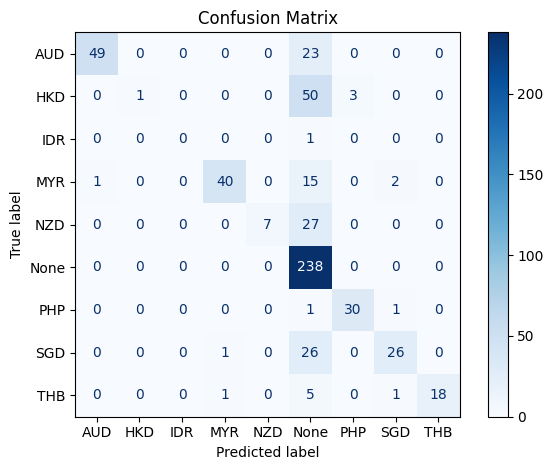

In [28]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=currency,
    y_pred=tar_currency,
    cmap="Blues",
    normalize=None
)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

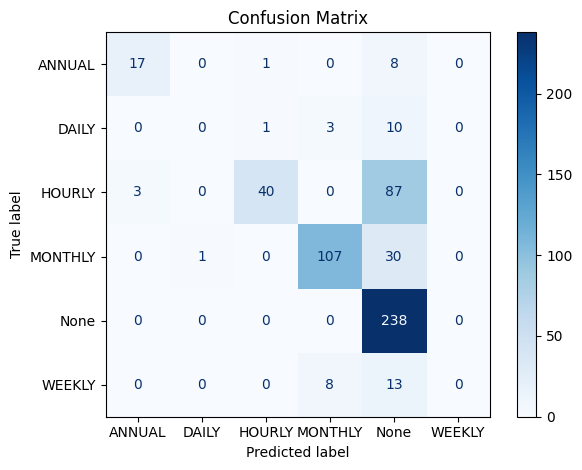

In [29]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=period,
    y_pred=tar_period,
    cmap="Blues",
    normalize=None
)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Compute the exact‐match accuracy across all four metrics.

In [30]:
exact_matches = sum(
    1
    for tm, pm, tx, px, tc, pc, tp, pp
    in zip(min, tar_min,
           max, tar_max,
           currency, tar_currency,
           period, tar_period)
    if tm == pm and tx == px and tc == pc and tp == pp
)

exact_acc = exact_matches / len(min)
print(f"Exact match rate (min,max,currency,period): {exact_acc:.4f}")

Exact match rate (min,max,currency,period): 0.5679


In [31]:
exact_matches = sum(
    1
    for tm, pm, tx, px, tc, pc, tp, pp
    in zip(min, tar_min,
           max, tar_max,
           currency, tar_currency,
           period, tar_period)
    if (tm == pm or tm - 1 == pm or tm + 1 == pm) and (tx == px or tx - 1 == px or tx + 1 == px) and tc == pc and tp == pp
)

exact_acc = exact_matches / len(min)
print(f"Exact match rate (min,max,currency,period): {exact_acc:.4f}")

Exact match rate (min,max,currency,period): 0.5697
